# Проект: классификация

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme("notebook")
import plotly
import plotly.express as px
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
import category_encoders as ce
from sklearn.linear_model import LogisticRegression 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
import optuna
from sklearn.model_selection import cross_val_score

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
data = pd.read_csv('data/bank_fin.csv', sep = ';')

In [3]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
data.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [4]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
data['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

### Задание 3

In [5]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
# замена лишних знаков
data['balance'] = data['balance'].apply(lambda x: str(x).replace(',00', '').replace('$', '').replace(' ', ''))
data['balance'] = pd.to_numeric(data['balance'], errors='coerce')

# среднее значение столбца
data['balance'].mean().round(3)

1529.129

### Задание 4

In [6]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
data['balance'] = data['balance'].fillna(data['balance'].median())

# среднее значение столбца
data['balance'].mean().round(3)

1526.936

### Задание 5

In [7]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
job_top = data['job'].mode()[0]
edu_top = data['education'].mode()[0]
data['job'] = data['job'].apply(lambda x: job_top if x=='unknown' else x)
data['education'] = data['education'].apply(lambda x: edu_top if x=='unknown' else x)
data[(data['job']==job_top) & (data['education']==edu_top)]['balance'].mean().round(3)

1598.883

### Задание 6

In [8]:
des = data['balance'].describe()
des

count    11162.000000
mean      1526.936033
std       3224.829691
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1699.000000
max      81204.000000
Name: balance, dtype: float64

In [9]:
iqr = des[6] - des[4] # межквартильный размах
nq = des[4] - 1.5*iqr # нижняя граница
vq = des[6] + 1.5*iqr # верхняя граница
nq.round(), vq.round()

(-2241.0, 4063.0)

In [10]:
# удалите все выбросы для признака balance
index_names = data[(nq>data['balance']) | (data['balance']>vq)].index
data.drop(index_names, inplace=True)
data['balance'].count()

10105

## Часть 2:  Разведывательный анализ

### Задание 1

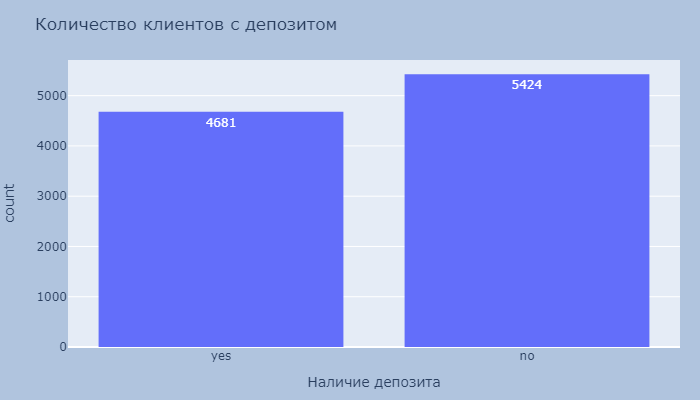

In [11]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
fig = px.histogram(
    data['deposit'], height=400, width=700, text_auto=True,
    title='Количество клиентов с депозитом',
    labels={'value':'Наличие депозита'}
)

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue',
    showlegend=False
)

fig.show('png')

### Задания 2 и 3

In [12]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'balance'}>,
        <Axes: title={'center': 'day'}>],
       [<Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'campaign'}>,
        <Axes: title={'center': 'pdays'}>],
       [<Axes: title={'center': 'previous'}>, <Axes: >, <Axes: >]],
      dtype=object)

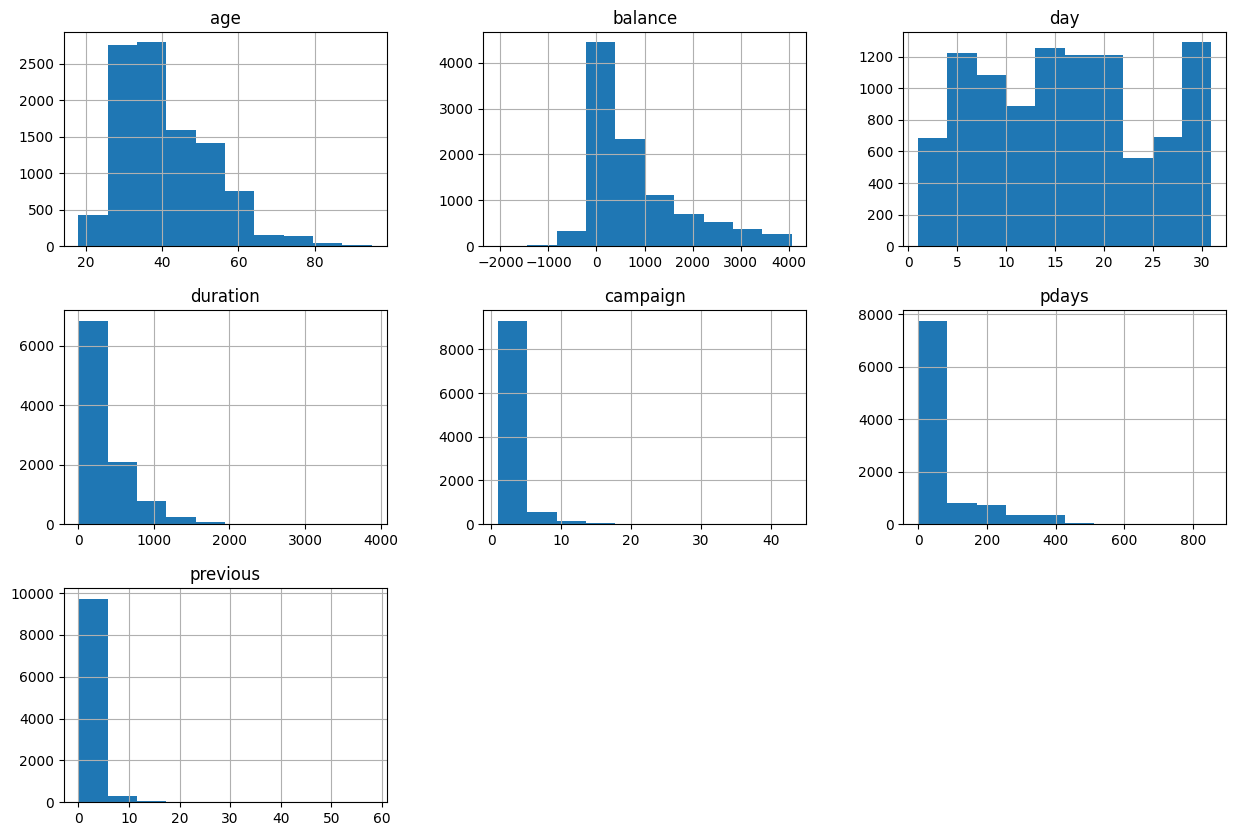

In [13]:
data.hist(figsize=(15,10))

### Задания 4 и 5

In [14]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
data.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


Признаки 'default', 'housing' и 'loan' являются бинарными. Почти у всех клиентов в выборке есть или был просроченный кредит(признак 'default').

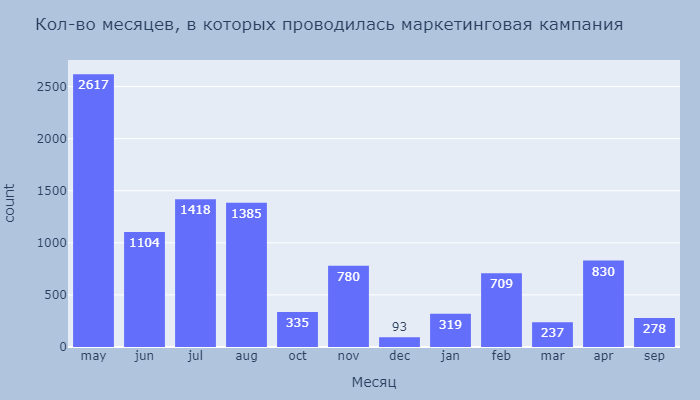

In [15]:
fig = px.histogram(
    data['month'], height=400, width=700, text_auto=True,
    title='Кол-во месяцев, в которых проводилась маркетинговая кампания',
    labels={'value':'Месяц'}
)

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue',
    showlegend=False
)

fig.show('png')

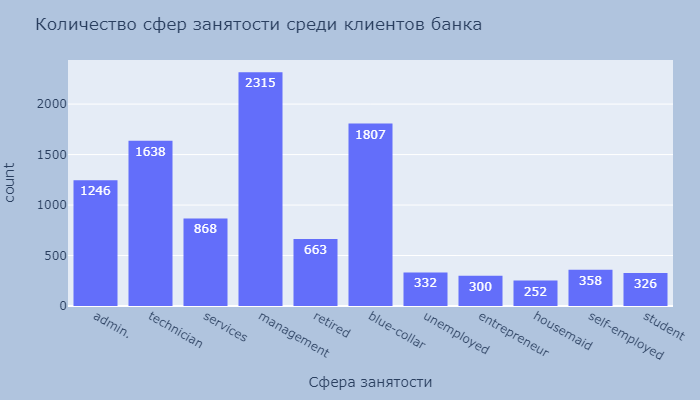

In [16]:
fig = px.histogram(
    data['job'], height=400, width=700, text_auto=True,
    title='Количество сфер занятости среди клиентов банка',
    labels={'value':'Сфера занятости'}
)

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue',
    showlegend=False
)

fig.show('png')

### Задание 6

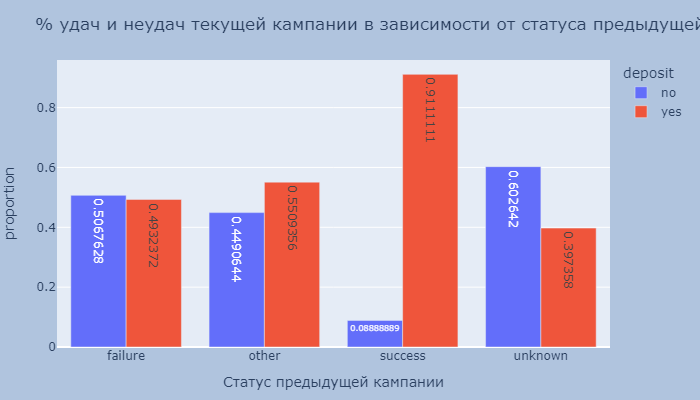

In [17]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
df_26 = data.groupby('poutcome', as_index=False)['deposit'].value_counts(normalize=True)

fig = px.bar(
    df_26,
    x='poutcome', y='proportion', height=400, width=700, text_auto=True,
    barmode='group', color='deposit',
    title='% удач и неудач текущей кампании в зависимости от статуса предыдущей',
    labels={'poutcome':'Статус предыдущей кампании'}
)

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue'
)

fig.show('png')

### Задание 7

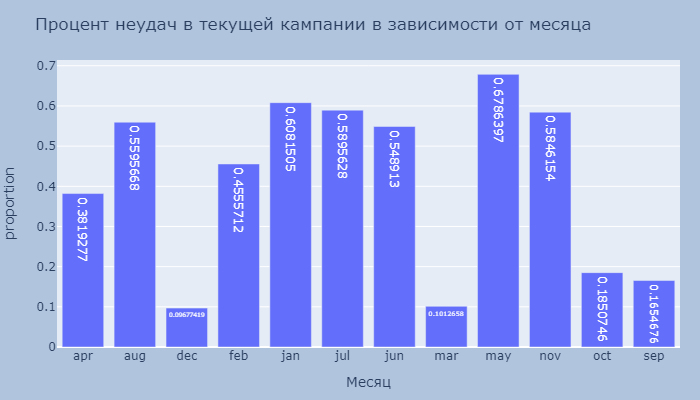

In [18]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
df_27 = data.groupby('month', as_index=False)['deposit'].value_counts(normalize=True)

fig = px.bar(
    df_27[df_27['deposit']=='no'],
    x='month', y='proportion', height=400, width=700, text_auto=True,
    title='Процент неудач в текущей кампании в зависимости от месяца',
    labels={'month':'Месяц'}
)

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue',
    showlegend=False
)

fig.show('png')

### Задание 8

In [19]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

data['age'] = pd.to_numeric(data['age'], errors='coerce') #меняем тип на числовой

def cat_age(age):
    if age < 30:
        return '<30'
    elif age in range (30, 40):
        return '30-40'
    elif age in range (40, 50):
        return '40-50'
    elif age in range (50, 60):
        return '50-60'
    elif age >= 60:
        return '60+'
    
data['age'] = data['age'].apply(cat_age)

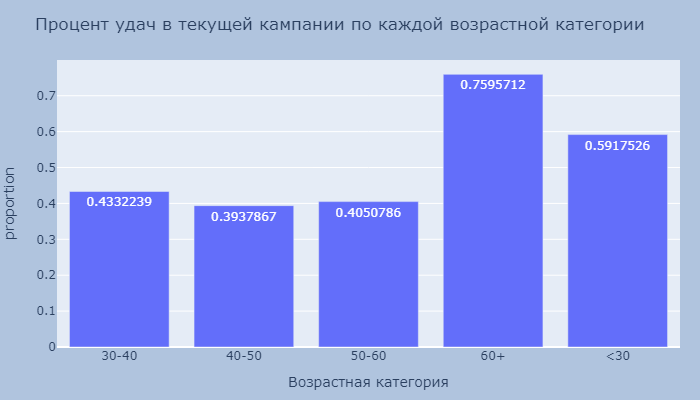

In [20]:
df_28 = data.groupby('age', as_index=False)['deposit'].value_counts(normalize=True)

fig = px.bar(
    df_28[df_28['deposit']=='yes'],
    x='age', y='proportion', height=400, width=700, text_auto=True,
    title='Процент удач в текущей кампании по каждой возрастной категории',
    labels={'age':'Возрастная категория'}
)

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue',
    showlegend=False
)

fig.show('png')

### Задания 9 и 10

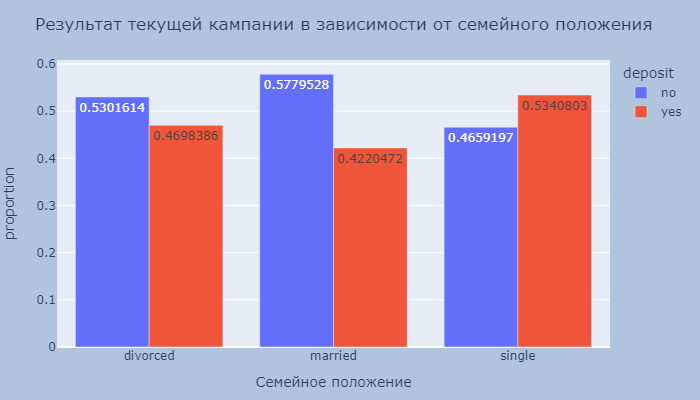

In [21]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

df_291 = data.groupby('marital', as_index=False)['deposit'].value_counts(normalize=True)

fig = px.bar(
    df_291,
    x='marital', y='proportion', height=400, width=700, text_auto=True,
    color='deposit', barmode='group',
    title='Результат текущей кампании в зависимости от семейного положения',
    labels={'marital':'Семейное положение'}
)

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue'
)

fig.show('png')

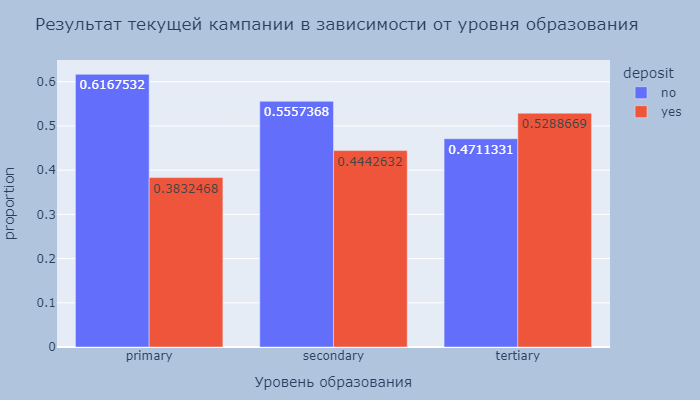

In [22]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образованияdf_391 = data.groupby('marital', as_index=False)['deposit'].value_counts(normalize=True)

df_292 = data.groupby('education', as_index=False)['deposit'].value_counts(normalize=True)

fig = px.bar(
    df_292,
    x='education', y='proportion', height=400, width=700, text_auto=True,
    color='deposit', barmode='group',
    title='Результат текущей кампании в зависимости от уровня образования',
    labels={'education':'Уровень образования'}
)

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue'
)

fig.show('png')

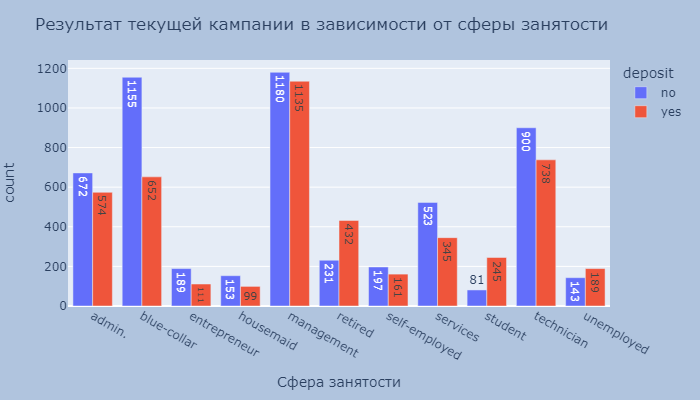

In [23]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

df_293 = data.groupby('job', as_index=False)['deposit'].value_counts()

fig = px.bar(
    df_293,
    x='job', y='count', height=400, width=700, text_auto=True,
    color='deposit', barmode='group',
    title='Результат текущей кампании в зависимости от сферы занятости',
    labels={'job':'Сфера занятости'}
)

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue'
)

fig.show('png')

### Задание 11

In [24]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

df_211 = data.pivot_table(
    values='age',
    index=['marital', 'education'],
    columns='deposit',
    aggfunc='count'
)
df_211

deposit               no   yes
marital  education            
divorced primary      91    96
         secondary   370   283
         tertiary    163   174
married  primary     641   339
         secondary  1830  1289
         tertiary    832   784
single   primary     100    82
         secondary   866   879
         tertiary    531   755

## Часть 3: преобразование данных

### Задание 1

In [29]:
# преобразуйте уровни образования

label_encoder = LabelEncoder()

data['education'] = label_encoder.fit_transform(data['education'])
data['education'].sum()

11995

In [30]:
data['age'] = label_encoder.fit_transform(data['age'])

### Задания 2 и 3

In [36]:
# преобразуйте бинарные переменные в представление из нулей и единиц

data['deposit'] = data['deposit'].apply(lambda x: 1 if x=='yes' else 0)

data['deposit'].std().round(3)

0.499

In [40]:
data['default'] = data['default'].apply(lambda x: 1 if x=='yes' else 0)
data['housing'] = data['housing'].apply(lambda x: 1 if x=='yes' else 0)
data['loan'] = data['loan'].apply(lambda x: 1 if x=='yes' else 0)

In [42]:
round((data['default'].mean() + data['housing'].mean() + data['loan'].mean()), 3)

0.635

### Задание 4

In [69]:
#ohe_cols=['job', 'marital', 'contact', 'month', 'poutcome']
#encoder = ce.OneHotEncoder(use_cat_names=True)
#for i in ohe_cols:
#    temp = encoder.fit_transform(df[i])
#    df = pd.concat([df, temp], axis=1)

In [76]:
# создайте дамми-переменные
data = pd.get_dummies(data)

In [77]:
len(data.columns)

45

### Задания 5 и 6

Text(0.5, 1.0, 'Тепловая карта корреляции признаков')

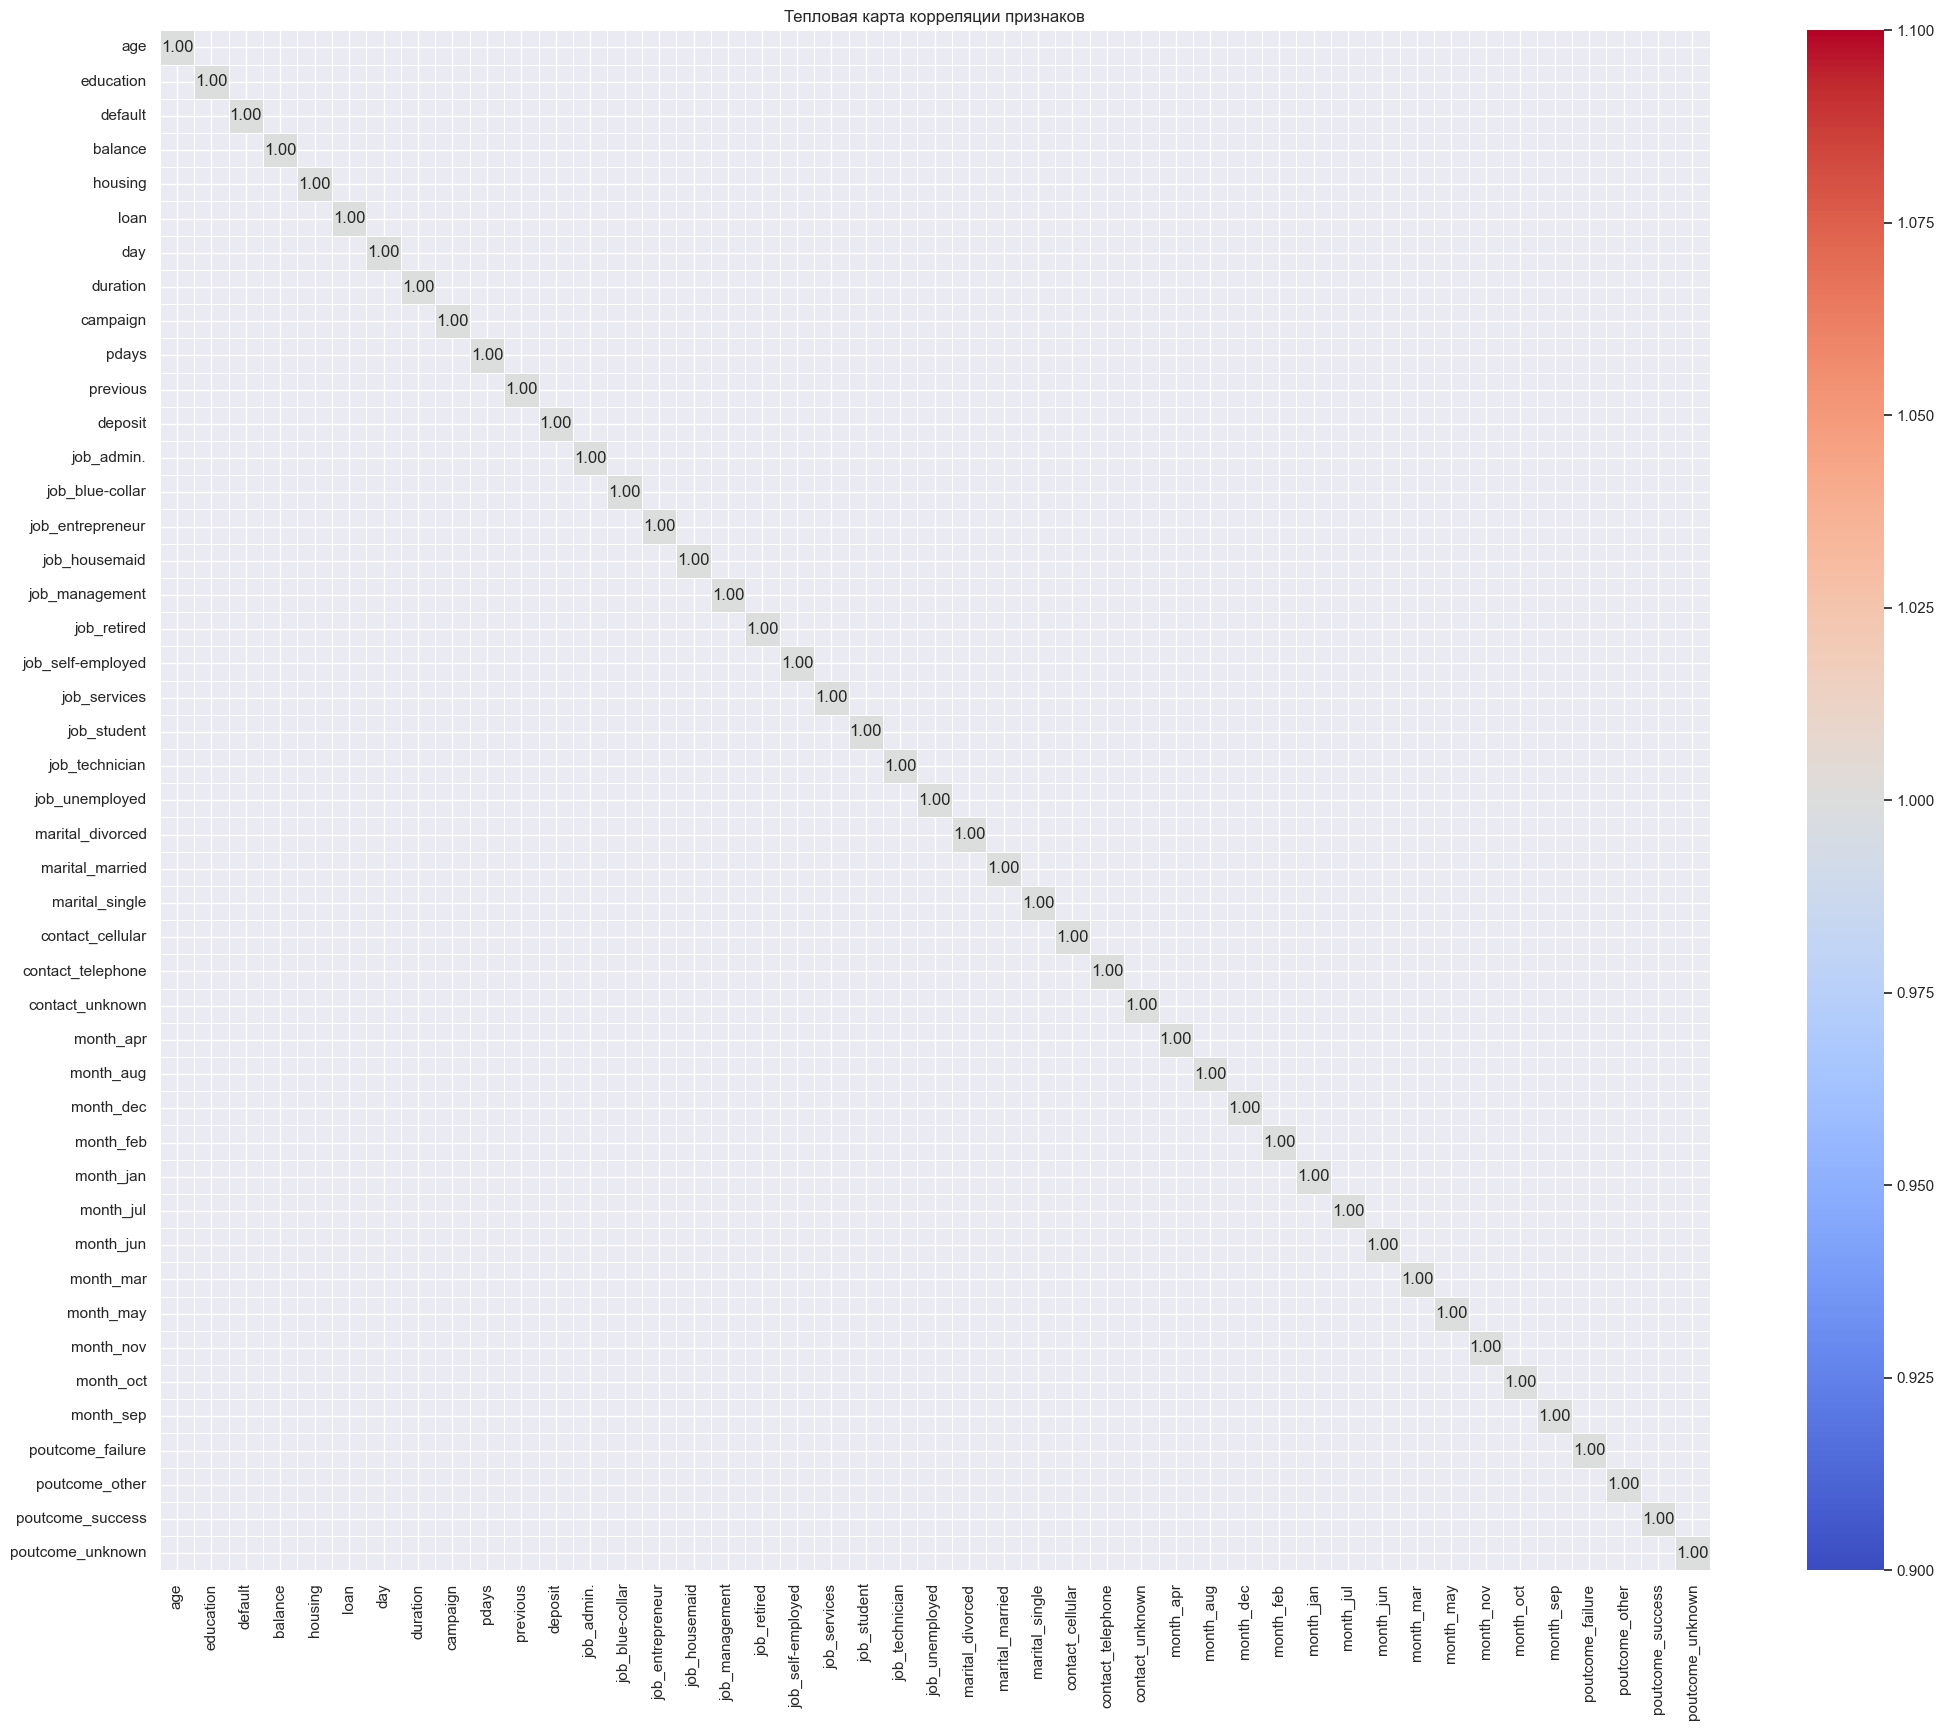

In [102]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

df_corr = data.corr(numeric_only=True)

fig = plt.figure(figsize = (25,20))
ax = sns.heatmap(df_corr[0.9<=df_corr.abs()], fmt='.2f', linewidths=.4, cmap='coolwarm', annot=True)
ax.set_title('Тепловая карта корреляции признаков')

In [103]:
df_corr[df_corr['deposit'].abs()>0.2]['deposit'].abs().sort_values()

housing             0.200290
contact_cellular    0.223944
poutcome_unknown    0.228300
contact_unknown     0.249294
poutcome_success    0.288491
duration            0.457818
deposit             1.000000
Name: deposit, dtype: float64

### Задания 7 и 8

In [147]:
X = data.drop(['deposit'], axis=1)
y = data['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [148]:
# рассчитайте необходимые показатели

X_test.shape[0]
y_test.mean().round(2)

0.46

### Задание 9

In [149]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['age', 'balance', 'housing', 'duration', 'campaign', 'pdays',
       'previous', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

### Задание 10

In [150]:
# нормализуйте данные с помощью minmaxsxaler
col_names = list(X_train.columns)
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=col_names)
X_test = pd.DataFrame(X_test, columns=col_names)
X_test['balance'].mean().round(2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [181]:
# обучите логистическую регрессию и рассчитайте метрики качества

#Создаем объект класса логистическая регрессия
log_reg = LogisticRegression(solver='sag', max_iter = 1000, random_state=42)
#Обучаем модель
log_reg.fit(X_train, y_train)
#Выводим значения метрики
y_test_pred = log_reg.predict(X_test)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1790
           1       0.82      0.77      0.80      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.81      0.81      3335
weighted avg       0.82      0.82      0.82      3335



### Задания 2,3,4

In [188]:
# обучите решающие деревья, настройте максимальную глубину

dt = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=6, random_state=42)
#Обучаем модель
dt.fit(X_train, y_train)
#Выводим значения метрики
y_test_pred = dt.predict(X_test)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1790
           1       0.76      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.80      3335
weighted avg       0.81      0.81      0.81      3335



### Задание 5

In [170]:
# подберите оптимальные параметры с помощью gridsearch

# зададим пространство поиска гиперпараметров
param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7]
              }

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid,
    cv=5,
    n_jobs = -1
)

#Обучаем модель
%time grid_search.fit(X_train, y_train)

#Выводим значения метрики 
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 344 ms
Wall time: 5.71 s
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [171]:
# обучите на ваших данных случайный лес

rf = ensemble.RandomForestClassifier(n_estimators = 100, criterion='gini',
                                     min_samples_leaf=5, max_depth=10, random_state=42)
#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики
y_test_pred = rf.predict(X_test)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1790
           1       0.81      0.85      0.83      1545

    accuracy                           0.84      3335
   macro avg       0.84      0.84      0.84      3335
weighted avg       0.84      0.84      0.84      3335



### Задания 2 и 3

In [177]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

gb = GradientBoostingClassifier(n_estimators = 300, learning_rate = 0.05,
                                     min_samples_leaf=5, max_depth=5, random_state=42)
#Обучаем модель
gb.fit(X_train, y_train)
#Выводим значения метрики
y_test_pred = gb.predict(X_test)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1790
           1       0.82      0.87      0.85      1545

    accuracy                           0.85      3335
   macro avg       0.85      0.85      0.85      3335
weighted avg       0.85      0.85      0.85      3335



### Задание 4

In [189]:
# объедините уже известные вам алгоритмы с помощью стекинга

estimators = [
    ('lr', LogisticRegression(solver='sag', max_iter = 1000, random_state=42)),
    ('dt',  DecisionTreeClassifier(criterion = 'entropy', max_depth=6, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators = 300, learning_rate = 0.05,
                                     min_samples_leaf=5, max_depth=5, random_state=42))
]

# Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=42)
)
# Обучаем модель
reg.fit(X_train, y_train)

#Выводим значения метрики
y_test_pred = reg.predict(X_test)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86      1790
           1       0.83      0.86      0.84      1545

    accuracy                           0.85      3335
   macro avg       0.85      0.85      0.85      3335
weighted avg       0.85      0.85      0.85      3335



### Задание 5

<Axes: >

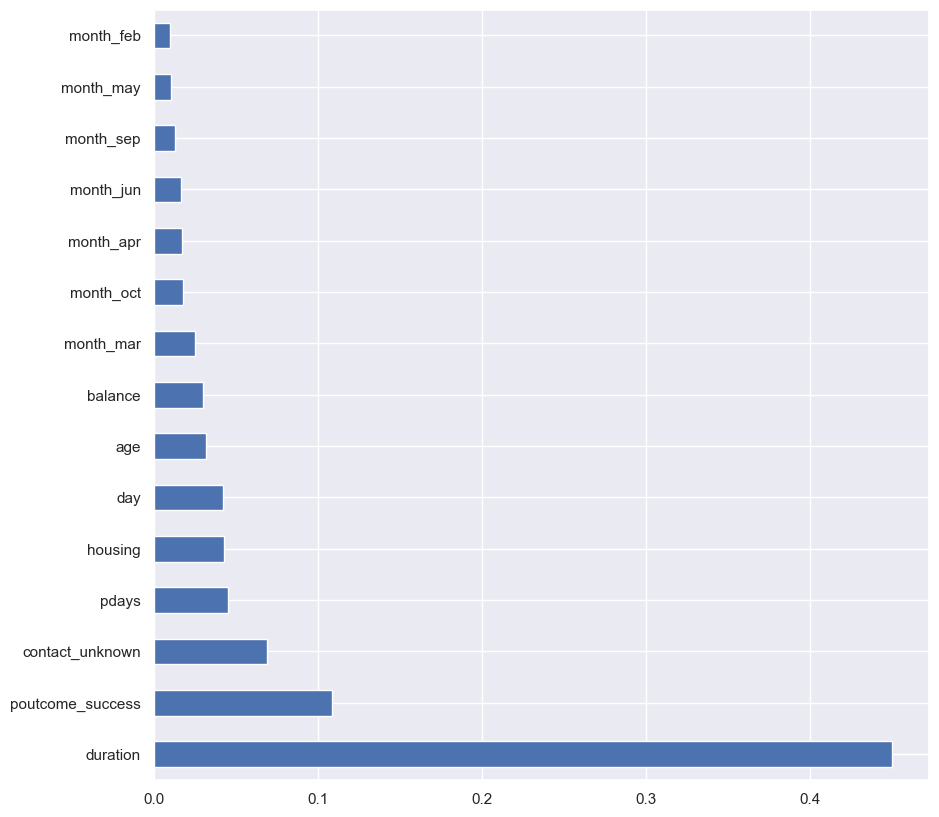

In [190]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(gb.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

### Задания 6,7,8

In [193]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

def optuna_rf(trial, cv=5):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train, y_train)
  score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

  return score

In [194]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_rf = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_rf.optimize(optuna_rf, n_trials=20)

[I 2024-05-30 18:40:34,188] A new study created in memory with name: RandomForestClassifier
[I 2024-05-30 18:40:41,073] Trial 0 finished with value: 0.7463488826120349 and parameters: {'n_estimators': 106, 'max_depth': 26, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7463488826120349.
[I 2024-05-30 18:40:48,512] Trial 1 finished with value: 0.773250134158166 and parameters: {'n_estimators': 156, 'max_depth': 28, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.773250134158166.
[I 2024-05-30 18:40:51,471] Trial 2 finished with value: 0.760051329929962 and parameters: {'n_estimators': 121, 'max_depth': 28, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.773250134158166.
[I 2024-05-30 18:40:54,514] Trial 3 finished with value: 0.7432232321948617 and parameters: {'n_estimators': 130, 'max_depth': 24, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.773250134158166.
[I 2024-05-30 18:40:57,343] Trial 4 finished with value: 0.7470870184351097 and parameters: {'n_esti

CPU times: total: 19.1 s
Wall time: 1min 19s


In [195]:
# рассчитаем точность для тестовой выборки
model_rf = ensemble.RandomForestClassifier(**study_rf.best_params,random_state=42)
model_rf.fit(X_train, y_train)
y_test_pred_rf = model_rf.predict(X_test)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86      1790
           1       0.83      0.86      0.84      1545

    accuracy                           0.85      3335
   macro avg       0.85      0.85      0.85      3335
weighted avg       0.85      0.85      0.85      3335

